# Семинар 8 Эндогенность в регрессии и проверка предположений Гаусса-Маркова

In [ ]:
import pandas as pd
import numpy as np




1) Проверка остатков на нормальность

Тесты:

1.   Колмогорова Смирнова( малая мощность, если выборка не большая)
2.   Андресона Дарлинг
3.   В ряде опытов, особенно в медицинских исследованиях, численность выборки мала. Специально для проверки нормальности распределения малых, численностью от трех до пятидесяти элементов, выборок Шапиро и Уилк разработали критерий $W$.

Что если не нормальные? что ломается?
Эффективность оценок

2) Проверка сколерированности остатков
Тест Дарбина-Ватсона (проверяет сущетсвует ли автокорреляция 1 порядка)

3) Проверка на гетероскедастичность

4) Проверка на эндогенность


<center>
<img src="../logo.png" height="900">
</center>


#  Регрессия - моя профессия



In [ ]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Данные

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/FUlyankin/matstat-AB/main/week13_linreg/data/Advertising.csv', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


__Описание колонок:__

- `Sales` - продажи продукта на данном рынке (в тысячах штук)
- `TV` -  доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах

В нашей выборке мы имеем 200 **наблюдений** (200 разных рынков с разным объёмом рекламы)

## Вопросы

Давайте представим, что мы работаем на компанию, которая производит и продает этот товар. Компания может задать нам вопрос: как мы должны тратить наши рекламные деньги в будущем?

Этот общий вопрос может привести вас к более конкретным вопросам:

1. Существует ли связь между рекламой и продажами?
2. Насколько сильны эти отношения?
3. Какие типы рекламы способствуют росту продаж?
4. Зная расходы на рекламу на конкретном рынке, можем ли мы предсказать продажи?

# 1. Парная регрессия в уровнях

Взглянем как продажи зависят от типов рекламы.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


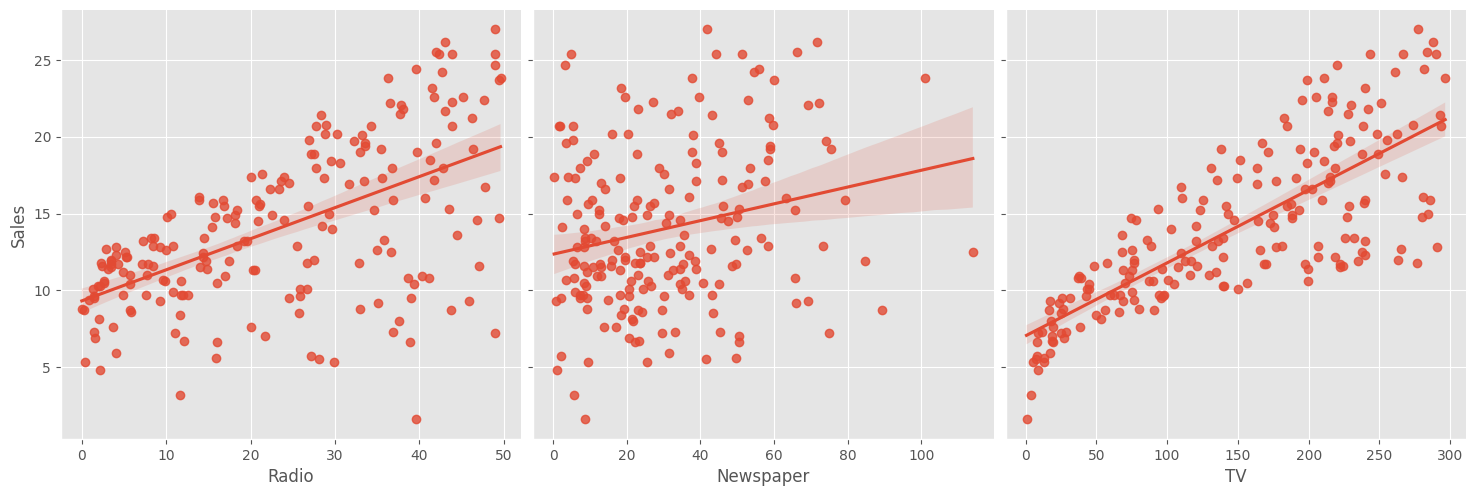

In [ ]:
sns.pairplot(
    df,
    y_vars='Sales',
    x_vars=['Radio', 'Newspaper', 'TV'],
    size=5,
    kind='reg',
    diag_kind=None
);

Для начала давайте поговорим только про рекламу на TV. Оценим параметры модели

$$
Sales_i = \beta_0 + \beta_1 \cdot TV_i + \varepsilon_i
$$

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('Sales ~ TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           1.47e-42
Time:                        10:00:24   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

In [ ]:
res.params

Intercept    7.032594
TV           0.047537
dtype: float64

- Переменная $TV$ значима, так как $p$-значение для проверки гипотезы о том, что она равна нулю оказалось очень маленьким, наблюдаемое значение статистики $17.668$. Оно лежит глубоко в хвосте нашего распределения.
- Получившееся уравнение

$$
Sales_i = 7.033 + 0.047 \cdot TV_i
$$

можно проинтерпретировать так, что каждые дополнительные $1000$ долларов, потраченные на рекламу по телевизору, увеличивают продажы на $47.537$ товаров.

> Мы можем так интерпретировать значение коэффициента, если выполняются предпослыки линейной регрессии. Например, первая предпослыка говорит о том, что мы должны были верно специфицировать модель.

Если модель специфицирована неверно, у нас есть проблемы.

> Мы получаем корректные оценки стандартных ошибок в ситуации, когда ошибки независимо одинаково распределены с одинаковой дисперсией. Если это не так, оценки ошибок искажены.

# 2. Парная регрессия в логарифмах

У нашей модели явно есть проблемы со спецификацией. Давайте попробуем их исправить. Если взглянуть на график того, как между собой взаимосвязаны реклама по TV и продажи, можно заметить нелинейную зависимость, похожую на логарифмическую.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


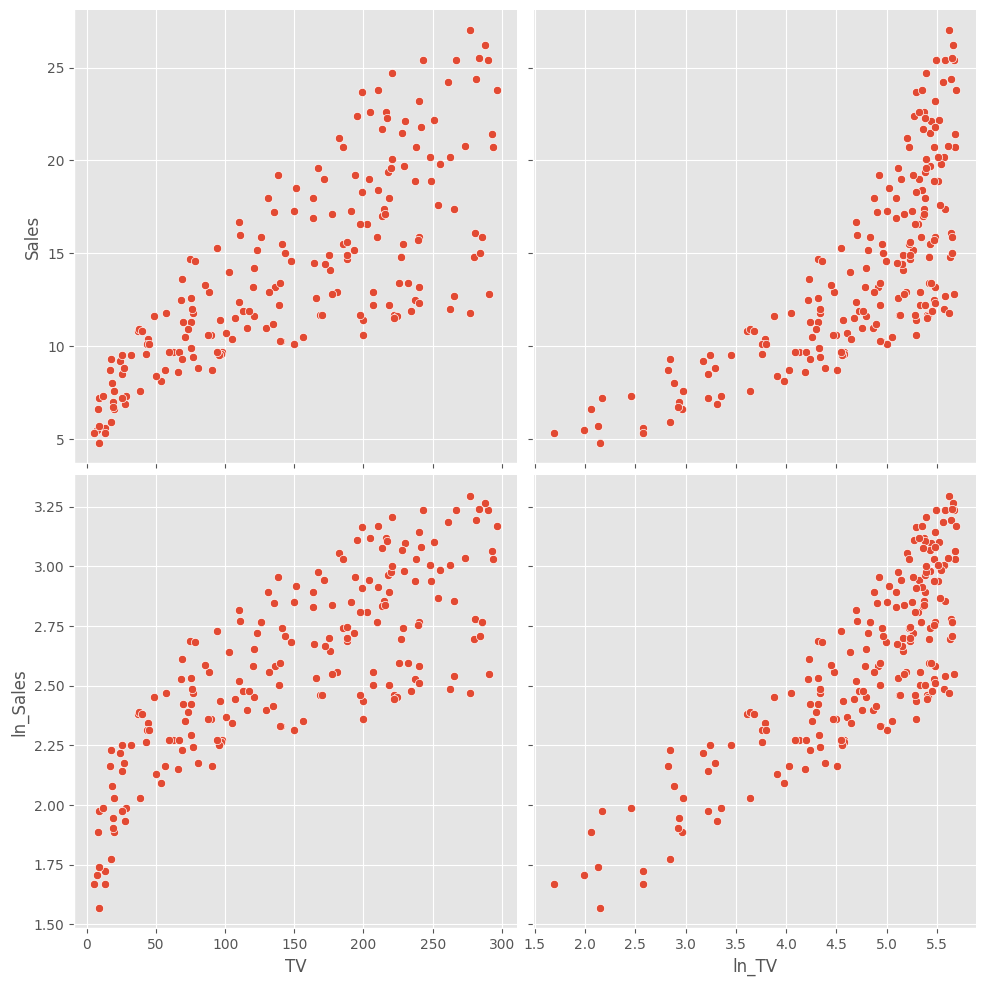

In [ ]:
df['ln_TV'] = df['TV'].apply(np.log)
df['ln_Sales'] = df['Sales'].apply(np.log)

sns.pairplot(
    df,
    y_vars=['Sales', 'ln_Sales'],
    x_vars=['TV', 'ln_TV'],
    size=5,
    diag_kind=None
);


Очистим данные от выбросов.

In [ ]:
df = df[df.Sales > df.Sales.quantile(0.01)]

Оценим параметры модели

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \varepsilon_i
$$

In [ ]:
import statsmodels.formula.api as smf

model = smf.ols('ln_Sales ~ ln_TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     371.7
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           7.20e-47
Time:                        12:12:56   Log-Likelihood:                 28.180
No. Observations:                 195   AIC:                            -52.36
Df Residuals:                     193   BIC:                            -45.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9902      0.085     11.696      0.0

Переменная снова значима. $R^2$ подрос. Все коэффициенты в моделях, где целевые и объясняющие переменные взяты в логарифмах, интерпретируются в процентных изменениях. Например, коэффициент $0.3550$ можно проинтерпретировать как то, на сколько процентов увеличутся продажи, при изменении трат на рекламу по телевизору на $1\%$.

# 3. Множественная регрессия

Оценим уравнение

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \beta_2 \cdot Radio_i + \beta_3 \cdot Newspaper_i + \varepsilon_i
$$

In [ ]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2820.
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          7.63e-158
Time:                        12:12:58   Log-Likelihood:                 295.31
No. Observations:                 195   AIC:                            -582.6
Df Residuals:                     191   BIC:                            -569.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6366      0.023     27.581      0.0

$F_{st} = \frac{R^{2}/(k-1)}{(1-R^{2}/(n-k)}$
k количество параметров в линейной регрессии.

- Уравнение значимо в целом, значение F-статистики попадает глубоко в хвост
- Коэффициент перед `Newspaper` отрицательный и незначимый

> Если модель специфицирована верно и выполнены все предпосылки, мы можем сделать вывод, что траты на рекламу в газетах никак не повышают продажи и от них можно отказаться

# 4. Проверка предпосылок модели

- Есть ли мультиколинеарность?(линейная зависимость признаков)


In [ ]:
df[['ln_TV', 'Radio', 'Newspaper']].corr()

,ln_TV,Radio,Newspaper
ln_TV,1.000000,-0.029214,-0.047141
Radio,-0.029214,1.000000,0.356063
Newspaper,-0.047141,0.356063,1.000000


Между переменными нет высокой корреляции. Значит у нас получится корректно оценить нашу модель. Есть другие, более формальне критерии для поиска проблем, связанных с мультиколинеарностью, но мы про них говорить не будем.

- Корректны ли данные, с которыми мы работаем, для решения поставленной задачи?
- Корректна ли спецификация модели?
- Есть ли выборосы?

Про всё это мы поговорили выше. Судя по всему, оценки коэффициентов, которые мы получили - несмещённые и состоятельные.

- Есть ли в остатках __автокоррелированность__?

Для проверки этой предпосылки нам достаточно посмотреть в протокол оценивания и найти там строчку `Durbin-Watson`. Это статистика Дарбина-Уотсона. Если она оказывается в районе двух, то автокоррелированности в остатках нет. На самом деле это тоже статистика и для неё есть формальные критические значения, но мы в это углубляться не будем. Есть и другие критерии для проверки этой предпосылки.

- Есть ли в остатках __гетероскедастичность__?

Для гетероскедастичности построим картинку и воспользуемся каким-нибудь критерием.

<ipython-input-27-bd412ab3cfd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = res.resid
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


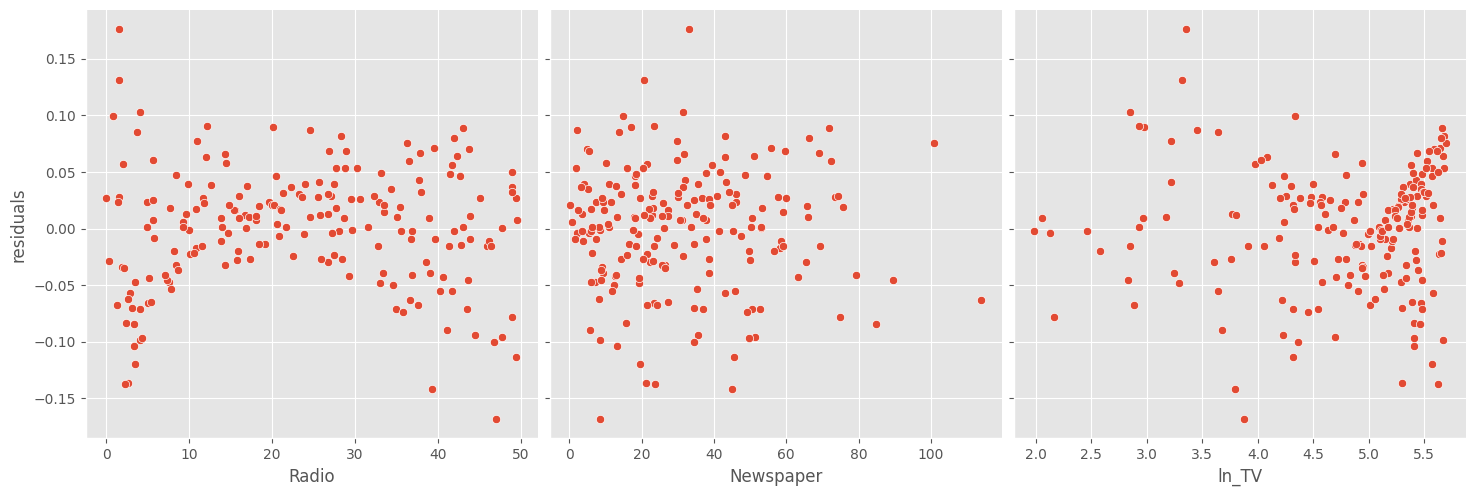

In [ ]:
df['residuals'] = res.resid

sns.pairplot(
    df,
    y_vars='residuals',
    x_vars=['Radio', 'Newspaper', 'ln_TV'],
    size=5,
    diag_kind=None
);

Судя по графику, дисперсия ошибок зависит от объёма рекламы по радио. Причём квадратично. Выходит, что оценки дисперсий коэффициентов искажены и доверительные интервалы оказываются смещёнными. Можно провести формальный тест на гомоскедастичность. Таких тестов есть довольно много.

[Breuch Pagan test](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%91%D1%80%D0%BE%D0%B9%D1%88%D0%B0_%E2%80%94_%D0%9F%D0%B0%D0%B3%D0%B0%D0%BD%D0%B0)

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, df[['ln_TV', 'Radio', 'Newspaper']].values)

(51.35841835091103,
 7.041434689102253e-12,
 22.765010819357567,
 1.1142274879410336e-12)

Видим, что `pvalue` (последнее значение) сильно ниже уровня значимости. Гипотеза о гомоскедастичности отвергается. Можно ввести корректировку и исправить значения ошибок прямо при оценивании модели.

In [ ]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2060.
Date:                Fri, 10 Nov 2023   Prob (F-statistic):          3.71e-145
Time:                        12:24:38   Log-Likelihood:                 295.31
No. Observations:                 195   AIC:                            -582.6
Df Residuals:                     191   BIC:                            -569.5
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6366      0.028     22.990      0.0

Значения стандартных ошибок довольно сильно изменились. Теперь мы можем использовать их для проверки гипотез.

> Нормальность остатков нам не нужна. Из-за корректировки ошибок мы можем пользоваться только асимптотическими результатами. В данных нет выбросов, поэтому предельные теоремы тут работают.

# 4. Выводы:

1. Тратить деньги на рекламу в газетах неэффективно. Гипотеза о том, что коэффициент перед этой переменной равен нулю, не отвергается.
2. Реклама по телевидению обладает убывающей отдачей от масштаба. Коэффициент перед логарифмом получился меньше единицы. Этот канал оказывается в плане рекламы самым эффективным.
3. Канал, связанный с радио, судя по всему, недоиспользуется. Здравый смысл и микроэкономика подсказывают, что от него тоже логично ожидать убывающую от масштаба отдачу. Однако в данных мы видим, что она линейная.

[Как интерпретировать summary in statmodeels.ols](https://habr.com/ru/articles/681218/)

# Эндогенность

**Проблема неправильной спецификации модели:**
Спецификация модели связана с выбором функциональной формы, которая используется для
анализа взаимосвязей между переменными. Фактически, первое предположение модели регрессии требует, чтобы модель была правильно задана. Другими словами, предполагается, что мы точно знаем, какие
переменные следует включить. Однако на практике никто не может быть абсолютно уверен в том, что выбранная функциональная форма является правильной, поэтому возможны ошибки в спецификации. Прежде всего, есть
две причины их существования:
1) формула неверна;
2)опущена значимая объясняющая переменная

## Simulation of endogenuity: Ommited variable bias

Что будет если не учесть переменную влияющую на Y?

Пусть корректная модель это: $Y =β_0+β_1 X_1 +β_2 X_2+ u$, гауссовский шум $u \sim N(0,1)$

Сгенерируем данные:

In [ ]:
import numpy as np
data_size = 100
x_1 =  np.linspace(300, 800, data_size) + np.random.normal(scale = 3, size = data_size)
x_2 = np.linspace(2, 2000, data_size) + np.random.normal(scale = 2, size = data_size)

true_beta_0 = 1
true_beta_1 = 3
true_beta_2 = 5
#generate Y as in model


Предположим исследователь хочет оценить модель линейной регрессии:
$Y =\alpha_0+\alpha_1 X_1 +\epsilon$, не учитывая переменную $X_2$.



In [ ]:
import tqdm

In [ ]:
import statsmodels.formula.api as smf # Модели
import pandas as pd

beta0_estimate_list = []
beta1_estimate_list = []
for i in tqdm.tqdm(range(2000)):
  Y = true_beta_0 +true_beta_1* x_1+true_beta_2*x_2 + np.random.normal(size = data_size)
  data = pd.DataFrame(np.vstack([x_1, Y]).T, columns=['x', 'Y'])
  model = smf.ols(data=data, formula='Y ~ x').fit()
  beta0_estimate_list.append(model.params[0])
  beta1_estimate_list.append(model.params[1])


100%|██████████| 2000/2000 [00:12<00:00, 155.91it/s]


Text(0.5, 1.0, 'Distribution of beta_1')

<Figure size 1000x1000 with 0 Axes>

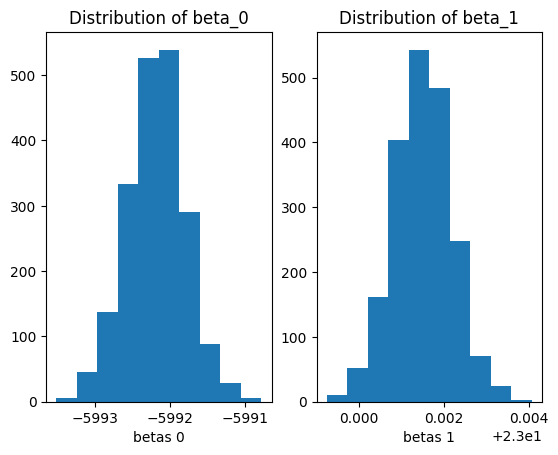

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols = 2)

axes[0].hist(beta0_estimate_list)
axes[0].set_xlabel("betas 0")
axes[0].set_title("Distribution of beta_0")

axes[1].hist(beta1_estimate_list)
axes[1].set_xlabel("betas 1")
axes[1].set_title("Distribution of beta_1")


Мы видим, что истинное значение   $\beta_0$  равно  1 не попадало в распределение оценки МНК $\hat \alpha_0$  на $\beta_0$, что  значит что оценка модели $Y =\alpha_0+\alpha_1 X_1 +\epsilon$ через МНК
$\hat \alpha_0$ на  $\beta_0$  ассимтотически смещенная.

Тоже самое, мы видим, что истинное значение   $\beta_1$  равно  3 не попадало в распределение оценки МНК $\hat \alpha_1$  на $\beta_1$, что  значит что оценка модели $Y =\alpha_0+\alpha_1 X_1 +\epsilon$ через МНК
$\hat \alpha_1$ на  $\beta_1$  ассимтотически смещенная.

Почему оценка получается смещенной при отстуствии в моделе важной объясняющей переменной?

Предположим исследователь хочет оценить модель линейной регрессии:
$Y =\alpha_0+\alpha_1 X_1 +\epsilon$, не учитывая переменную $X_2$.
Оценивая $\hat \alpha_0$ и $\hat \alpha_1$ через МНК:

$\hat \alpha_0  = \bar Y- \hat \alpha_1  \bar X_1$

$\hat \alpha_1 = \frac{\sum_{i=1}^{n}(Y_i-\bar Y)(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}$


Чтобы узнать, смещены ли оценки, посчитаем их матожидание:


$E[\hat \alpha_1] = E[\frac{\sum_{i=1}^{n}(E(Y_i-\bar Y|X_{1i})(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}]$

Так как по истинной модели $Y_i =β_0+β_1 X_{1i} +β_2 X_{2i}+ u$

То, $E(Y_i-\bar Y|X_{1i} )= (β_0+β_1 X_{1i} +β_2 X_{2i}+ u -β_0  - β_1 \bar X_{1} -β_2 \bar X_{2} - \bar u|X_{1i} ) = β_1(X_{1i}  - \bar X_{1}) +E( β_2 (X_{2i} - \bar X_{2})|X_{1i})  +  E(u_i-\bar u|X_{1i}) $


Тогда $$E[\hat \alpha_1] = \beta_1 +  β_2 \underbrace{E[\frac{\sum_{i=1}^{n}( (X_{2i} - \bar X_{2})|X_{1i})(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}]}_{\text{covariance  bias}} + \underbrace{E[\frac{\sum_{i=1}^{n}(  u_i-\bar u )|X_{1i})(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}]}_{\text{random component}}$$

Считая, что  $X_{1}$ не стохастический и что $X_{1}$ не коорелирует с шумом $u$, тогда $E(u_i-\bar u )|X_{1i}) = 0$ и тогда
$E[\hat \alpha_1] = \beta_1 + β_2  E[\frac{\sum_{i=1}^{n} (X_{2i} - \bar X_{2})(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}]$

Значит, $E[\hat \alpha_1] \neq \beta_1 $, то есть оценка смещена.

Величина смещения это $E[\hat \alpha_1]-\beta_1  = β_2  E[\frac{\sum_{i=1}^{n} (X_{2i} - \bar X_{2})(X_{1 i} - \bar X_1)}{\sum_{i=1}^{n}(X_{1 i} - \bar X_1)^{2}}  =β_2 \frac{Cov(X_2,X_1)}{Var(X_1)} $.

Также заметим, что при стремлении величины выборки $n$ к бесконечности,
Величина смещения не стремится к нулю, откуда следует, что. оценка является ассимтотически смещенной и значит, не состоятельной.


Аналогично, можно доказать, что оценка $\hat \alpha_0 $  является смещенной.

Также при проблеме отсутсвующей переменной(omitted variable bias) стандартные ошибки
и тесты становятся невалидны.

Визуализация 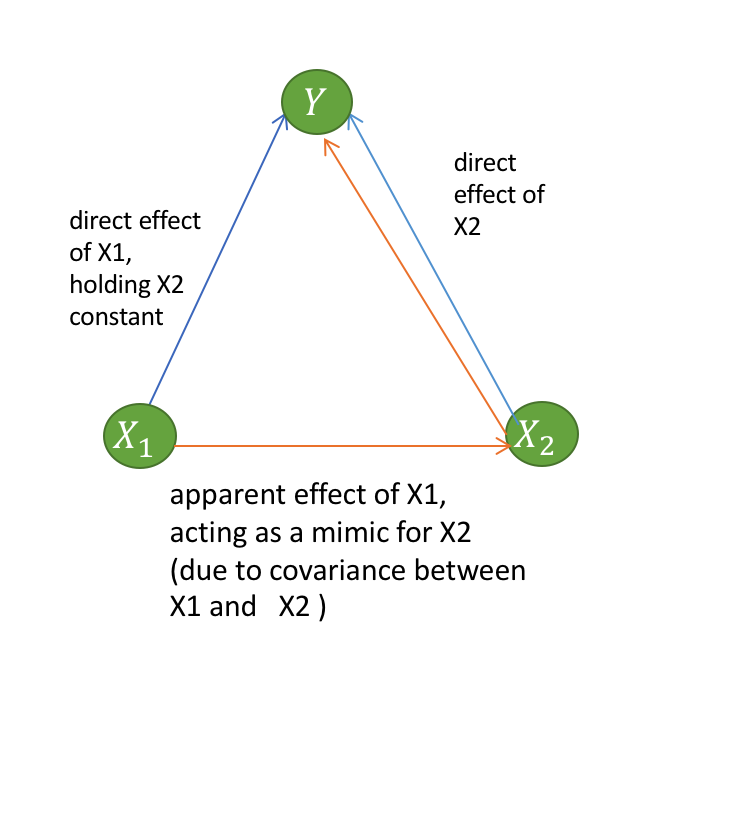

How to identify endogenuity? TSLS Durwin Wu Hausman test.
How to combat endogenuity? Instrumental variable

Если существует проблема с опущенной значимой переменной,
то в модели $Y = \alpha +\beta X + \epsilon$ появляется проблема, когда $ \epsilon$ сколерован с X, что нарушает предпоссылку Гаусса-Маркова о несколерированности остатков и регрессоров.



Мы можем справиться с проблемой эндогенности, применив оценку инструментальных переменных (IV). Инструментальные переменные Допустимая инструментальная переменная $Z$  - это специальная прокси- переменная, для которой должны выполняться следующие условия::
1. Инструмент экзогенность: он не коррелирует с остатком, т. е. $cov(Z,u) = 0$ ;)

2.Инструмент значим: он достаточно сильно коррелирует с соответствующей эндогенной переменной, т. е. $cov(Z,X) \neq 0$.
Основной целью применения инструментов является получение состоятельных оценок параметров.



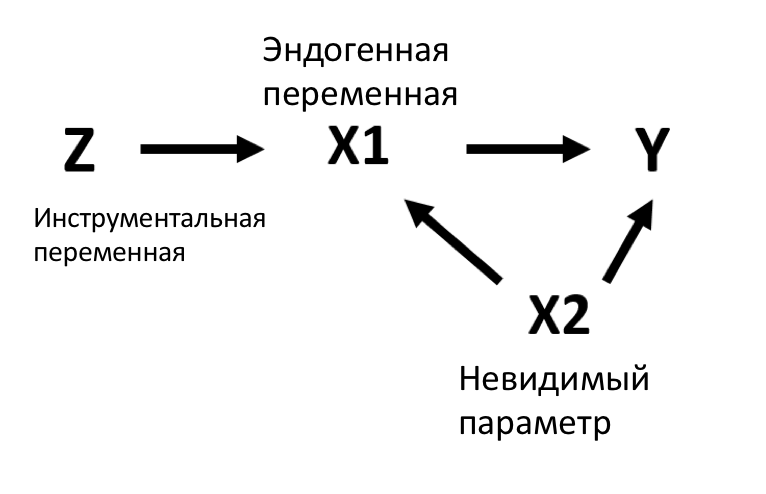

Тогда формула оценки интрументальной переменной (IV)
$\beta^{IV}= \frac{\sum_i(z_i y_i)}{\sum_iz_i x_i}=(Z^{T}X)^{-1}Z^Ty$

**Как выводиться инструментальная оценка?**

По предположению на инструментальную переменную $z$ должно выполняться  условие, что  $E(z_i e_i) = 0$,  где $e_i = y_i - x_i^{T} \beta$ это остаток.

Тогда $E(z_i y_i) - \beta E( z_i x_i^{T}) = 0$ откуда $\beta =(E( z_i x_i^{T}))^{-1} E(z_i y_i)$
Отсюда оценка методом мометнов(заменяя попляционные моменты на выборочные моменты) получается:
$\beta^{IV} = \frac{\frac{1}{n}\sum_i(z_i y_i)}{\frac{1}{n}\sum_i z_i x_i^{T}}$


Частично если переменная экзогенная, то она сама для себя будет инструментом.

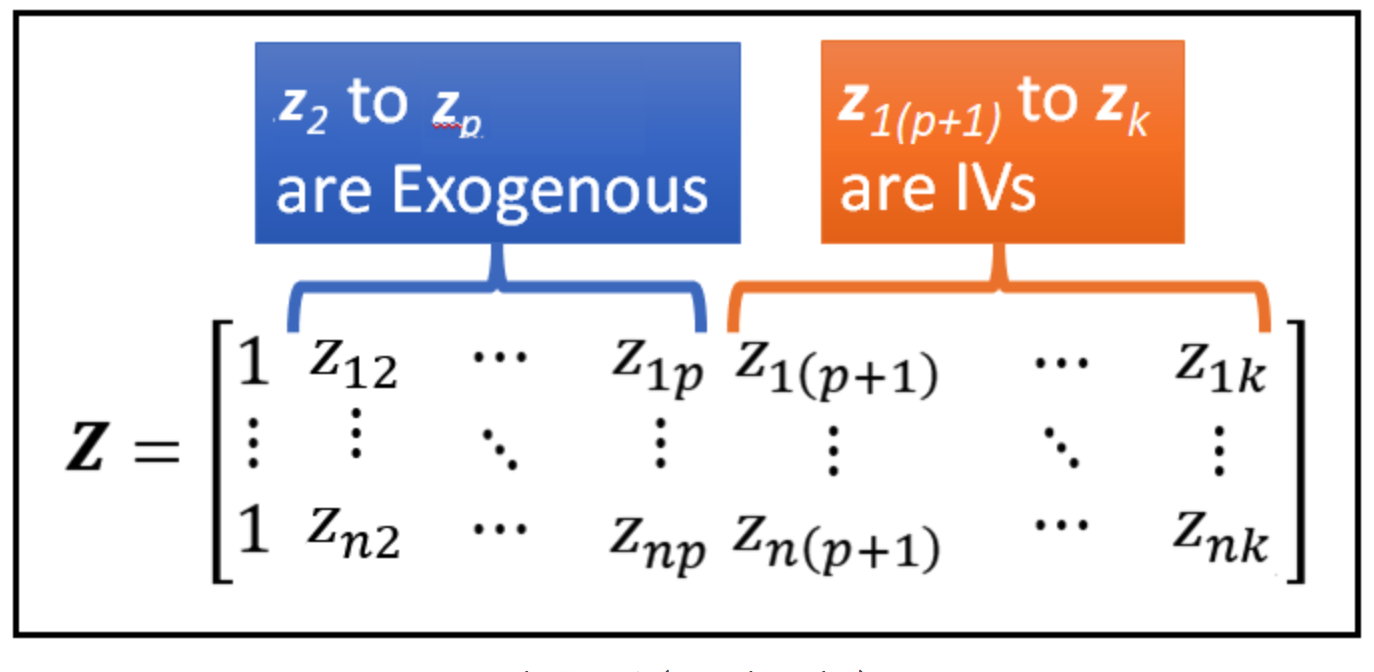

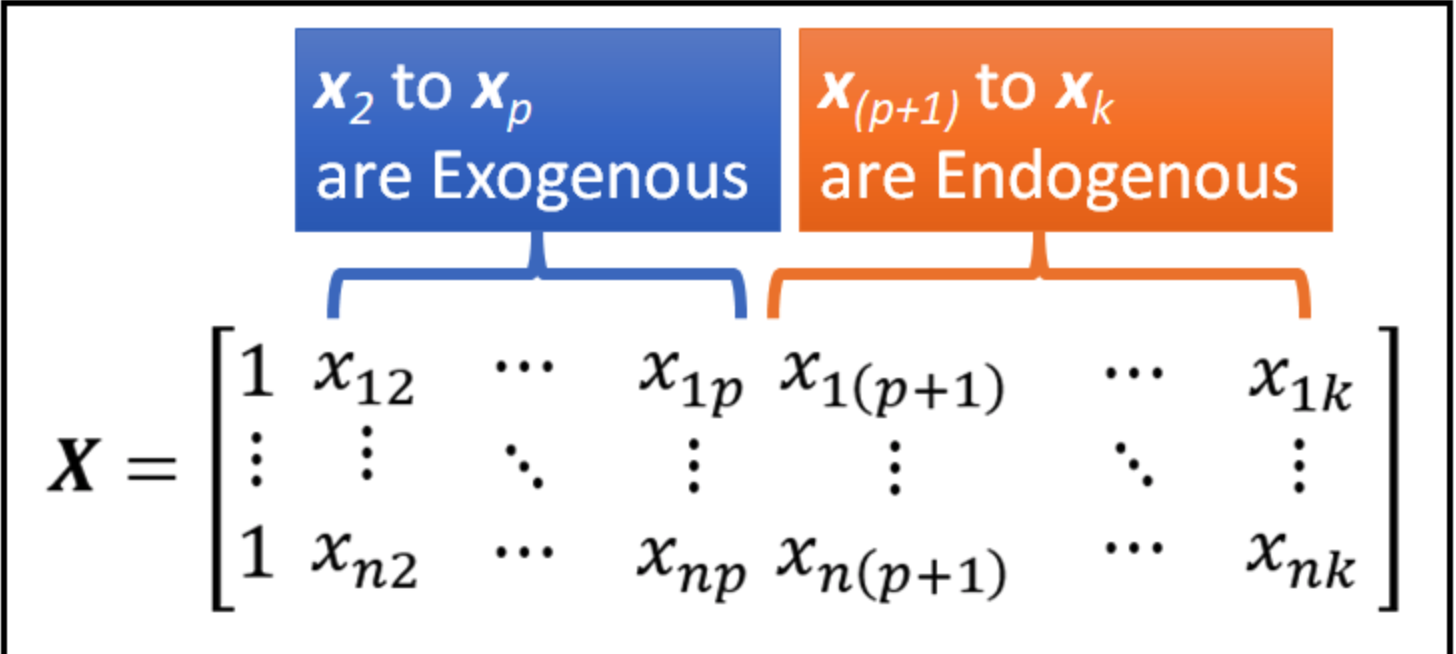

# Задача 2: Пример на инструментальную переменную

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS

In [ ]:
import pandas as pd
#Load the Panel Study of Income Dynamics (PSID) into a Dataframe

data = pd.read_csv("https://raw.githubusercontent.com/limph0nimph/psmo_linreg_classes/main/PSID1976.csv")
df_1975 = data.query('participation == \'yes\'')
df_1975['ln_wage'] = np.log(df_1975['wage'])


<ipython-input-34-1634c0ecdb51>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1975['ln_wage'] = np.log(df_1975['wage'])


In [ ]:
data.columns

Index(['rownames', 'participation', 'hours', 'youngkids', 'oldkids', 'age',
       'education', 'wage', 'repwage', 'hhours', 'hage', 'heducation', 'hwage',
       'fincome', 'tax', 'meducation', 'feducation', 'unemp', 'city',
       'experience', 'college', 'hcollege'],
      dtype='object')

Predict wage on education experience

We cannot include talant variable into regression as no full information on talant. But talant inbfluences education which imnplies that education will be calculated with the residual(as talant is an ommited variable).




Мы ходим понять как образование и опыт работы влияет на зарплату.
Однако мы также знаем, что важным фактором является талант(Ability), но талант это невидимая переменная и данных на неё у нас нет.

Таким образом, истинная модель выглядит так:
$Log wage=β0+β_1Education+β_2Ability+β_3Experience$

Но мы можем оценить регрессию вида:
$Log wage=\alpha_0+\alpha_1Education+\alpha_2 Experience$

Однако на образовние точно влияет талант(Ability). Тогда получается, что в данный модели будут проблема пропущенной переменной, так как
$cov(Education, Ability)>0$ и в данной регрессионной модели будут смещенные и несостоятельные оценки.

Что же делать, чтобы получить состоятельные оценки на параметры $\alpha_0,\alpha_1, \alpha_2$ можно для переменной Education использовать инструментальные переменные, связанные с Education, но **не** связанные с талантом Ability.

Например, образование родителей в целом определяет образование человека, но не зависит от его таланта(Ability).

Тогда в качестве инструментальных переменных будет использовать meducation(образование матери) и feducation (образование отца)



In [ ]:
import numpy as np
X_data = np.stack([np.ones(df_1975.shape[0]), df_1975['education'].values, df_1975['experience'].values]).T
Z_IV = np.stack([ df_1975['feducation'], df_1975['meducation'], df_1975['experience'].values]).T
y = df_1975['ln_wage']
beta_IV =  np.linalg.inv(Z_IV.T@X_data)@Z_IV.T@y
print(beta_IV)

[-1.47317101  0.18330255  0.02345972]


 # Сравним IV оецнку с IV TSLS Двухшаговый МНК
  Оценка двухшагового МНК(TSLS)

Почему оценка инсnрументального переменной эквивалентна процедуре двухшагового мнк с интсрументальной переменной, если число инструментов равно числу эндогенных переменных.

Вместо того, чтобы напрямую считать $\beta^{IV} = \frac{\frac{1}{n}\sum_i(z_i y_i)}{\frac{1}{n}\sum_i z_i x_i^{T}}$  можно сделать двухшагового МНК(TSLS или 2SLS) с инструментальной переменной.
Как?


1.   Оценить регрессию эндогенной переменной(education) на инструментальные переменные

2.   Затем, используя $\hat{education}$ (оценку эндогенной переменной из регрессии в пункте 1) построить регрессию таргет переменной от $\hat{education}$ и экзогенных переменных.







*   Шаг 1: Регрессия эндогенной переменной на инструменты $\hat{\gamma} = (Z^{T}Z)^{-1}Z^{T}X$.
Тогда $\hat{X} = Z\hat{\gamma}$
*  Шаг 2: $$\beta^{IV TSLS} = (\hat{X}^{T}X)^{-1}\hat{X}^{T}y$$

Тогда
 $$\beta^{IV TSLS} = ((Z\hat{\gamma})^{T}X)^{-1}(Z\hat{\gamma})^{T}y = (X^{T}Z(Z^{T}Z)^{-1}Z^{T}X)^{-1}X^{T}Z(Z^{T}Z)^{-1}Z^Ty  $$
Если число инструментов совпадает с количеством колонок матрицы $X$, то тогда $X^{T}Z$ квадратичная матрица и $(X^{T}Z(Z^{T}Z)^{-1}Z^{T}X)^{-1}X^{T}Z(Z^{T}Z)^{-1}Z^Ty  =(Z^{T}X)^{-1} Z^{T}Z (X^{T}Z)^{-1} X^{T}  Z (Z^{T}Z)^{-1}Z^Ty   = (Z^{T}X)^{-1} Z^Ty  =  \beta^{IV}$, то оценка интсрументвльной переменной(IV) совпдает с оценкой двухшагового МНК(TSLS)

при количество инструментов равно количество

IV TSLS by hands:

In [ ]:
X_data = np.stack([np.ones(df_1975.shape[0]), df_1975['education'].values, df_1975['experience'].values]).T
Z_IV = np.stack([ df_1975['feducation'].values, df_1975['meducation'].values, df_1975['experience'].values]).T
#step1 of TSLS
gamma =  np.linalg.inv(Z_IV.T@Z_IV)@Z_IV.T@X_data
print("gamma", gamma)
X_hat = Z_IV@gamma
print(X_hat.shape)
#step of TSLS:
beta_TSLS =  np.linalg.inv(X_hat.T@X_data)@X_hat.T@y
print(beta_TSLS)

gamma [[ 2.99848166e-02  4.68547613e-01  2.77555756e-16]
 [ 4.59358830e-02  5.84075280e-01 -1.02695630e-15]
 [ 1.73150145e-02  1.73555295e-01  1.00000000e+00]]
(428, 3)
[-1.47317101  0.18330255  0.02345972]


Давайте с помощью инструментальных переменных оценим education, чтобы проверить наличие связи между  meducation(образование матери) и feducation (образование отца) и education.

In [ ]:
#Build an train an OLS model that regresses education on meducation and feducation and verify
# using the F-test that coefficients of meducation and feducation are jointly significant
# significance
olsr_model = smf.ols(formula='education ~ meducation + feducation', data=df_1975)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     55.83
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           2.96e-22
Time:                        11:14:39   Log-Likelihood:                -910.64
No. Observations:                 428   AIC:                             1827.
Df Residuals:                     425   BIC:                             1839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4801      0.321     29.523      0.0

Да, зависят. Значит можем использовать их в качестве инструментов.

TSLS in statmodels:

In [ ]:
#Build out the exog matrix. Statsmodels requires this matrix to contain all the endogenous and
# exogenous variables, plus the constant.
exog = df_1975[['education',"experience"]]
exog = add_constant(exog)

#Build out the instruments matrix. Statsmodels requires this matrix to contain not only all the
# instruments but also the variables in exog that will NOT be instrumented
instruments = df_1975[['meducation', 'feducation',"experience"]]
#instruments = add_constant(instruments)

#Build and train the IV2SLS model
iv2sls_model = IV2SLS(endog=df_1975['ln_wage'], exog=exog, instrument=instruments)
iv2sls_model_results = iv2sls_model.fit()

iv2sls_model_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.084
Model:                         IV2SLS   Adj. R-squared:                  0.080
Method:                     Two Stage   F-statistic:                     3.396
                        Least Squares   Prob (F-statistic):             0.0344
Date:                Fri, 27 Oct 2023                                         
Time:                        23:34:06                                         
No. Observations:                 428                                         
Df Residuals:                     425                                         
Df Model:                           2                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4732      2.725     -0.541      0.589      -6.829       3.882
education      0.1833      0.197      0.931      0.352      -0.204       0.570
experience     0.0235      0.014      1.689      0.092      -0.004       0.051
==============================================================================
Omnibus:                       66.428   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.634
Skew:                          -0.664   Prob(JB):                     8.29e-51
Kurtosis:                       6.342   Cond. No.                         113.
==============================================================================
"""

Сравним поведение модели  of IV 2SLS with OLS of ln(wage) on education


In [ ]:
reg_expr = 'ln_wage ~ education + experience'
olsr_model = smf.ols(formula=reg_expr, data=df_1975)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_wage   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     37.02
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           1.51e-15
Time:                        23:19:14   Log-Likelihood:                -433.74
No. Observations:                 428   AIC:                             873.5
Df Residuals:                     425   BIC:                             885.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4002      0.190     -2.102      0.0

Оценки не совпадают.

# Задача 4 Как  с помощью инструментальной переменной проверить наличие эндогенности в модели?
**Durbin-Wu-Hausman specification test**

Для проверки гипотезы об эндогенности можно было бы использовать тест Хаусмана. Оригинальный тест основан на сравнении коэффициентов регрессии инструментальных переменных с обычной регрессией OLS с использованием критерия хи-квадрат со степенями свободы, равными количеству
сравниваемых параметров. При нулевой гипотезе об отсутствии одновременного смещения уравнения и OLS, и IV будут согласованными оценками, но OLS будет более эффективным. Согласно альтернативной гипотезе, МНК будут противоречивыми, и это видно из значения теста (значительно отличающегося
коэффициенты двух регрессий). Тест позволяет провести различие между этими двумя возможностями.
$H_0$: разница в коэффициентах не является систематической ((u_i не зависит от регрессоров) правильная спецификация <=> нет эндогенности)

Оценщик $\beta^{OLS}$ непротиворечив при H_1 и эффективен при H_0
Оценщик $\beta^{IV}$ согласован при H_0 и H_1

Однако, если тестовая статистика незначительна, это не обязательно означает, что нулевая гипотеза верна. Возможно, это неверно, но инструменты, используемые в IV, настолько слабы, что различия между оценками IV и OLS несущественны.

Существует другой подход к тесту эндогенности, основанный на методе Дэвидсона-Маккиннона:

1. Оцените исходную модель: $Y = \beta_1+\beta_2 X +u$ ;

2. Оцените регрессию эндогенной переменной на инструменте (инструментах), сохраните остатки: $X = \alpha_1+ \alpha_2 Z +v $, где
$Z$ - это возможный инструмент. Позволь
$resid = X - \hat \alpha_1 - \hat \alpha_2 Z $ - переменная, состоящая
из остатков в этой оценочной регрессии;

3. Добавьте остатки в качестве дополнительного регрессора в исходную модель:
$Y = \beta_1+\beta_2 X + +\beta_3resid+ u$
4. Проверьте значимость коэффициента наклона $\beta_3$. Если эта новая переменная незначительна – значит, разница в коэффициентах не является систематической (оценки OLS согласованы) =>
используйте исходную модель. Если это существенно – значит, разница систематическая, используйте инструментальную переменную.
Это асимптотический тест, и t-статистику следует сравнить с критическими значениями из стандартной нормы.

In [ ]:
#regression of X on instrument
reg_expr = 'education ~ meducation + feducation'
olsr_model_iv = smf.ols(formula=reg_expr, data=df_1975)
olsr_model_iv_results = olsr_model_iv.fit()
print(olsr_model_iv_results.summary())
residual = olsr_model_iv_results.resid

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     55.83
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           2.96e-22
Time:                        23:38:50   Log-Likelihood:                -910.64
No. Observations:                 428   AIC:                             1827.
Df Residuals:                     425   BIC:                             1839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4801      0.321     29.523      0.0

In [ ]:
import statsmodels.api as sm
import numpy as np

X = np.stack([np.ones(df_1975.shape[0]), df_1975['education'].values,residual]).T
Y = df_1975['ln_wage']
model = sm.OLS(Y,X,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     30.85
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           3.10e-13
Time:                        23:45:11   Log-Likelihood:                -439.10
No. Observations:                 428   AIC:                             884.2
Df Residuals:                     425   BIC:                             896.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5510      0.399      1.380      0.168      -0.234       1.336
x1             0.0505      0.031      1.606      0.109      -0.011       0.112
x2             0.0734      0.035      2.078      0.038       0.004       0.143
==============================================================================
Omnibus:                       87.954   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.164
Skew:                          -0.930   Prob(JB):                     3.96e-61
Kurtosis:                       6.484   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Видим, что коэффициент при $x_2$(residual) значим, так как t-статистика не входит в доверительный интервал,

Так как коэффициент значим, это показывает, что имеет место быть проблемв эндогенности.

# Задача 5 Монте Карло по оценки инструментальной переменной

Experiment on generated data:



look at different distributions of beta instrumental variable estimator
for different sample size

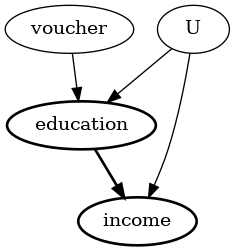

In [ ]:
import seaborn as sns
beta_iv_dist = []
beta_ols_dist = []
for i in range(1000):
  n_points = 1000
  education_abilty = 1
  education_voucher = 2
  income_abilty = 2
  income_education = 4


  # confounder
  ability = np.random.normal(0, 3, size=n_points)

  # instrument
  voucher = np.random.normal(2, 1, size=n_points)

  # treatment
  education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
              education_voucher * voucher

  # outcome
  income = np.random.normal(10, 3, size=n_points) +\
          income_abilty * ability + income_education * education

  # build dataset (exclude confounder `ability` which we assume to be unobserved)
  data = np.stack([education, income, voucher]).T
  df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

  Z_IV =  np.stack([np.ones(n_points),df["voucher"].values]).T
  X_data =  np.stack([np.ones(n_points), df["education"].values]).T
  y = df["income"].values
  beta_IV =  np.linalg.inv(Z_IV.T@X_data)@Z_IV.T@y
  beta_iv_dist.append(beta_IV[1])
  beta_ols = sm.OLS(y,X_data).fit().params[1]
  beta_ols_dist.append(beta_ols)


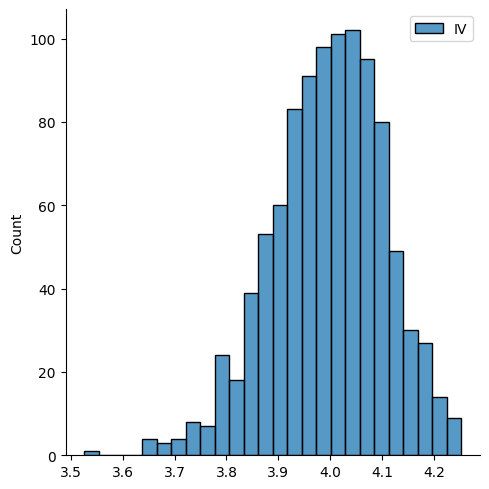

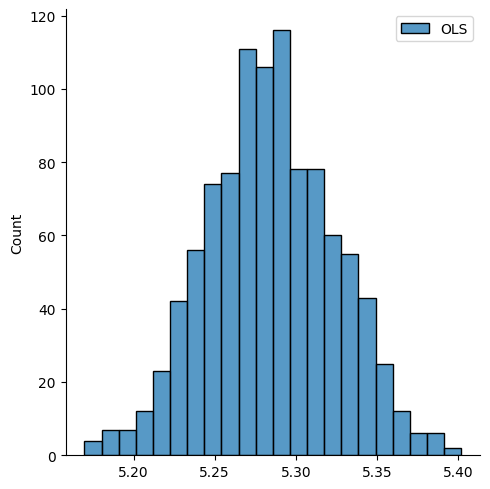

In [ ]:
import matplotlib.pyplot as plt

sns.displot(beta_iv_dist,label = "IV")
plt.legend()
sns.displot(beta_ols_dist,label = "OLS")
plt.legend()

Видим, что оцнка инструментальной преременной центрирована около 4, что является инстинным значением параментра income_education.
В отличие от нее, оценка методом OLS в условиях эндогенноссти, видно , что смещена и несостоятельна.